In [1]:
import datasets
import nltk
import torch
from collections import Counter
from nltk.corpus import stopwords
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torch import nn

In [2]:
dataset = datasets.load_dataset('okite97/news-data')

  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
nltk.download('stopwords')
stopwords.words('english')
stopwords_list = stopwords.words('english') + ['amp', '&amp', '\'']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
tokenizer = get_tokenizer('basic_english')

In [5]:
# Defining a Token list
def define_title_tokens(row):
      tokens = tokenizer(row['Title']) if row['Title'] else tokenizer(row['Excerpt'])
      tokens = [token for token in tokens if token not in stopwords_list]
      row['tokens'] = tokens
      return row

new_dataset = dataset.map(define_title_tokens)

In [6]:
# Getting all tokens list
all_tokens = []
for tokenlist in new_dataset['train']['tokens']:
  all_tokens.extend(tokenlist)

In [7]:
token_count = Counter(all_tokens)

In [8]:
vocab   = [token for token in set(all_tokens) if token_count[token] > 3]
vocab.append('<unk>')

classes = [classe for classe in dataset['train']['Category']]
classes = set(classes)

In [9]:
id2token = dict(enumerate(vocab))
token2id = {v: k for k, v in id2token.items()}

id2class = dict(enumerate(classes))
class2id = {v: k for k, v in id2class.items()}

In [10]:
def re_filter_title_tokens(row):
  tokens = tokenizer(row['Title']) if row['Title'] else tokenizer(row['Excerpt'])
  tokens = [token for token in tokens if token in vocab]
  
  if not len(tokens): tokens = ['<unk>']

  row['tokens'] = tokens
  return row

filtered_dataset = new_dataset.map(re_filter_title_tokens)

  0%|          | 0/4686 [00:00<?, ?ex/s]

  0%|          | 0/828 [00:00<?, ?ex/s]

In [11]:
def numerize_tokens(row):
  tokens_id = [token2id[token] for token in row['tokens']]
  row['tokens_id'] = tokens_id
  return row

filtered_dataset = filtered_dataset.map(numerize_tokens)

  0%|          | 0/4686 [00:00<?, ?ex/s]

  0%|          | 0/828 [00:00<?, ?ex/s]

In [12]:
def numerize_classes(row):
  result = [0] * len(class2id)
  result[(class2id[row['Category']])] = 1
  row['class_id'] = result
  return row

filtered_dataset = filtered_dataset.map(numerize_classes)

  0%|          | 0/4686 [00:00<?, ?ex/s]

  0%|          | 0/828 [00:00<?, ?ex/s]

In [13]:
class NewsDataset(Dataset):
  def __init__(self, dataset, vocab_size):
    self.dataset = dataset
    self.vocab_size = vocab_size
    self.data = dataset['tokens_id']
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    result = torch.zeros(self.vocab_size)
    return result.index_fill(0, torch.tensor(self.data[idx]), 1), torch.tensor(self.dataset['class_id'][idx], dtype=torch.float32)

In [14]:
dataloader = DataLoader(NewsDataset(filtered_dataset['train'], len(vocab)), shuffle=True)

In [15]:
class NewsClassifier(nn.Module):
  def __init__(self, vocab_size):
    super().__init__()

    self.linear_stack = nn.Sequential(
        nn.Linear(vocab_size, 6),
        nn.Softmax()
    )
  
  def forward(self, input):
    return self.linear_stack(input)

In [16]:
model = NewsClassifier(len(vocab))

device = torch.device('cuda')
model.to(device)

NewsClassifier(
  (linear_stack): Sequential(
    (0): Linear(in_features=2311, out_features=6, bias=True)
    (1): Softmax(dim=None)
  )
)

In [17]:
LR = 3e-4
EPOCHS = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [18]:
from tqdm import tqdm

progress_bar = tqdm(range(EPOCHS*len(dataloader)))

running_loss = []
for epoch in range(EPOCHS):

  epoch_loss = 0
  for X, y in dataloader:
    X, y = X.to(device), y.to(device)
    out = model(X)

    loss = loss_fn(out, y)
    epoch_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    progress_bar.update(1)

  epoch_loss = epoch_loss / len(dataloader)
  running_loss.append(epoch_loss)
  print('epoch loss:', epoch_loss)

  0%|          | 0/93720 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
  5%|▌         | 4690/93720 [01:39<28:36, 51.86it/s]

epoch loss: 1.7154354380838799


 10%|█         | 9383/93720 [03:17<29:38, 47.42it/s]

epoch loss: 1.5669848565560756


 15%|█▌        | 14069/93720 [04:54<28:25, 46.69it/s]

epoch loss: 1.475678446681592


 20%|██        | 18754/93720 [06:32<26:47, 46.63it/s]

epoch loss: 1.4169334717861262


 25%|██▌       | 23433/93720 [08:08<22:32, 51.97it/s]

epoch loss: 1.3758445235841354


 30%|███       | 28124/93720 [09:46<22:58, 47.59it/s]

epoch loss: 1.3448573000350672


 35%|███▌      | 32811/93720 [11:23<20:22, 49.81it/s]

epoch loss: 1.3198817421420233


 40%|████      | 37496/93720 [13:00<17:46, 52.74it/s]

epoch loss: 1.299320816128772


 45%|████▌     | 42182/93720 [14:38<17:35, 48.82it/s]

epoch loss: 1.2821107781243741


 50%|█████     | 46868/93720 [16:15<18:06, 43.14it/s]

epoch loss: 1.2676846165205238


 55%|█████▌    | 51552/93720 [17:53<14:21, 48.95it/s]

epoch loss: 1.2553965507843938


 60%|██████    | 56240/93720 [19:31<12:45, 48.93it/s]

epoch loss: 1.2446297562076554


 65%|██████▌   | 60924/93720 [21:09<10:45, 50.81it/s]

epoch loss: 1.2351676477258449


 70%|███████   | 65611/93720 [22:47<09:06, 51.46it/s]

epoch loss: 1.2268185936331089


 75%|███████▌  | 70298/93720 [24:24<08:03, 48.49it/s]

epoch loss: 1.2192766772494883


 80%|████████  | 74983/93720 [26:01<06:24, 48.70it/s]

epoch loss: 1.2126221742530283


 85%|████████▌ | 79670/93720 [27:38<05:01, 46.56it/s]

epoch loss: 1.2065687713794


 90%|█████████ | 84357/93720 [29:15<03:19, 46.89it/s]

epoch loss: 1.201154739516849


 95%|█████████▌| 89039/93720 [30:51<01:28, 53.02it/s]

epoch loss: 1.1963098429229286


100%|█████████▉| 93717/93720 [32:27<00:00, 45.19it/s]

epoch loss: 1.191824335701894


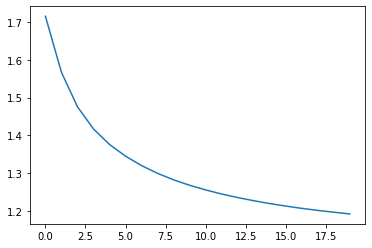

In [19]:
import matplotlib.pyplot as plt
plt.plot(running_loss)

In [20]:
dataloader_test = DataLoader(NewsDataset(filtered_dataset['test'], len(vocab)), shuffle=True)

In [21]:
import numpy as np

correct = 0
total = 0

for X, y in dataloader_test:
  model.eval()
  X, y = X.to(device), y.to(device)
  out = model(X)

  out_cpu = out.cpu().detach().numpy()
  label_cpu = y.cpu().detach().numpy().astype(int)

  predicted_label = np.argmax(out_cpu)
  actual_label = np.argmax(label_cpu)

  correct += np.sum(predicted_label == actual_label)
  total += 1

print(correct/total)

0.8514492753623188


Consegui apenas 85% com 20 epocas. O modelo foi arquitetado de forma bem simples, só tem uma hidden layer e uma softmax, pretendo melhorar um pouco depois, mas foi isso que consegui por enquanto!

